In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [2]:
data = pd.read_csv("CandidateSummaryAction1.csv")
data.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_str2,can_cit,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,cov_sta_dat,cov_end_dat,winner,votes
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,NaN,AUGUSTA,...,"$60,109.57","$175,613.35","$1,074,949.50","$907,156.21","$1,125,000.00",NaN,1/1/2015,10/19/2016,Y,158708.0
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,NaN,PHILADELPHIA,...,NaN,"$105,687.23","$1,406,719.06","$1,298,831.83",NaN,NaN,11/2/2015,10/19/2016,Y,310770.0
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,NaN,JACKSONVILLE,...,NaN,"$35,645.09","$650,855.38","$656,210.29","$60,000.00",NaN,4/1/2016,10/19/2016,Y,286018.0
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,NaN,WHITEFISH,...,"$83,815.78","$399,122.61","$4,938,943.74","$5,055,942.15",NaN,NaN,1/1/2015,10/19/2016,Y,280476.0
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",NaN,OAKLAND,...,"$83,690.60","$181,338.23","$1,197,676.61","$949,488.98","$4,401.75",NaN,1/1/2015,10/19/2016,Y,277390.0


In [3]:
data.shape

(1814, 51)

In [4]:

data['cov_sta_dat'] = pd.to_datetime(data['cov_sta_dat'])
data['cov_end_dat'] = pd.to_datetime(data['cov_end_dat'])

data['campaign_duration'] = (data['cov_end_dat'] - data['cov_sta_dat']).dt.days

In [5]:

def process_missing_data(data, threshold, inplace_value):
    #create a list to hold columns with missing value above threshold
    drop_cols = []
    
    #create a variable to store all columns in the dataframe
    all_cols = data.columns
    
    #calculate all columns with missing values percentage greater than the threshold
    missing_percentage = (data[all_cols].isna().sum()/len(data))*100
    
    #create a dataframe to store all candidate columns and their percentage
    missing_df = pd.DataFrame({"cols":all_cols, "percentage":missing_percentage})
    
    #check for threshold condition
    missing_filtered = missing_df[missing_df['percentage'] >= threshold] 
    drop_cols.append(missing_filtered["cols"].tolist())
    
    #drop candidate columns
    drop_cols = drop_cols[0]
    data.drop(columns=drop_cols, inplace= inplace_value)
    
    return data.shape

In [6]:
#call function on data
process_missing_data(data=data, threshold=90, inplace_value=True)

(1814, 42)

In [7]:
data['can_off'].value_counts(normalize=True, sort=True) * 100

can_off
H    78.776185
S    12.513782
P     8.710033
Name: proportion, dtype: float64

In [8]:
#first, convert the net_con column to a float data type and modify data inplace
def converter(data, data_col):
    value = data[data_col].str.replace('$','').str.replace(',','').str.replace('(','-').str.replace(')','').astype('float32')
    data[data_col] = value
    return data.head()

#call the function on the net_con feature
converter(data=data, data_col="net_ope_exp")

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,AUGUSTA,GA,...,"$60,109.57","$175,613.35","$1,074,949.50",9.071562e+05,"$1,125,000.00",2015-01-01,2016-10-19,Y,158708.0,657
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,PHILADELPHIA,PA,...,NaN,"$105,687.23","$1,406,719.06",1.298832e+06,NaN,2015-11-02,2016-10-19,Y,310770.0,352
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,JACKSONVILLE,FL,...,NaN,"$35,645.09","$650,855.38",6.562103e+05,"$60,000.00",2016-04-01,2016-10-19,Y,286018.0,201
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,WHITEFISH,MT,...,"$83,815.78","$399,122.61","$4,938,943.74",5.055942e+06,NaN,2015-01-01,2016-10-19,Y,280476.0,657
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",OAKLAND,CA,...,"$83,690.60","$181,338.23","$1,197,676.61",9.494890e+05,"$4,401.75",2015-01-01,2016-10-19,Y,277390.0,657


In [9]:
data['winner'] = data['winner'].fillna('N')

In [10]:
H_df = data.loc[data['can_off'] == "H"] 
S_df = data.loc[data['can_off'] == "S"]
P_df = data.loc[data['can_off'] == "P"]

In [11]:
#check the shape of the data

print(f'The shape of the House of assembly data is {H_df.shape}')
print(f'The shape of the senate data is {S_df.shape}')
print(f'The shape of the presidential data is {P_df.shape}')

The shape of the House of assembly data is (1429, 42)
The shape of the senate data is (227, 42)
The shape of the presidential data is (158, 42)


In [12]:
Amt_per_sta_ds = H_df.groupby(['can_off_sta', 'can_off_dis'])['net_ope_exp'].sum().to_frame(name = "total_dis_sum").reset_index()

In [13]:
Amt_per_sta_ds.head()

,can_off_sta,can_off_dis,total_dis_sum
0,AK,0.0,1145563.625
1,AL,1.0,941648.875
2,AL,2.0,1557982.250
3,AL,3.0,880649.750
4,AL,4.0,1319197.125


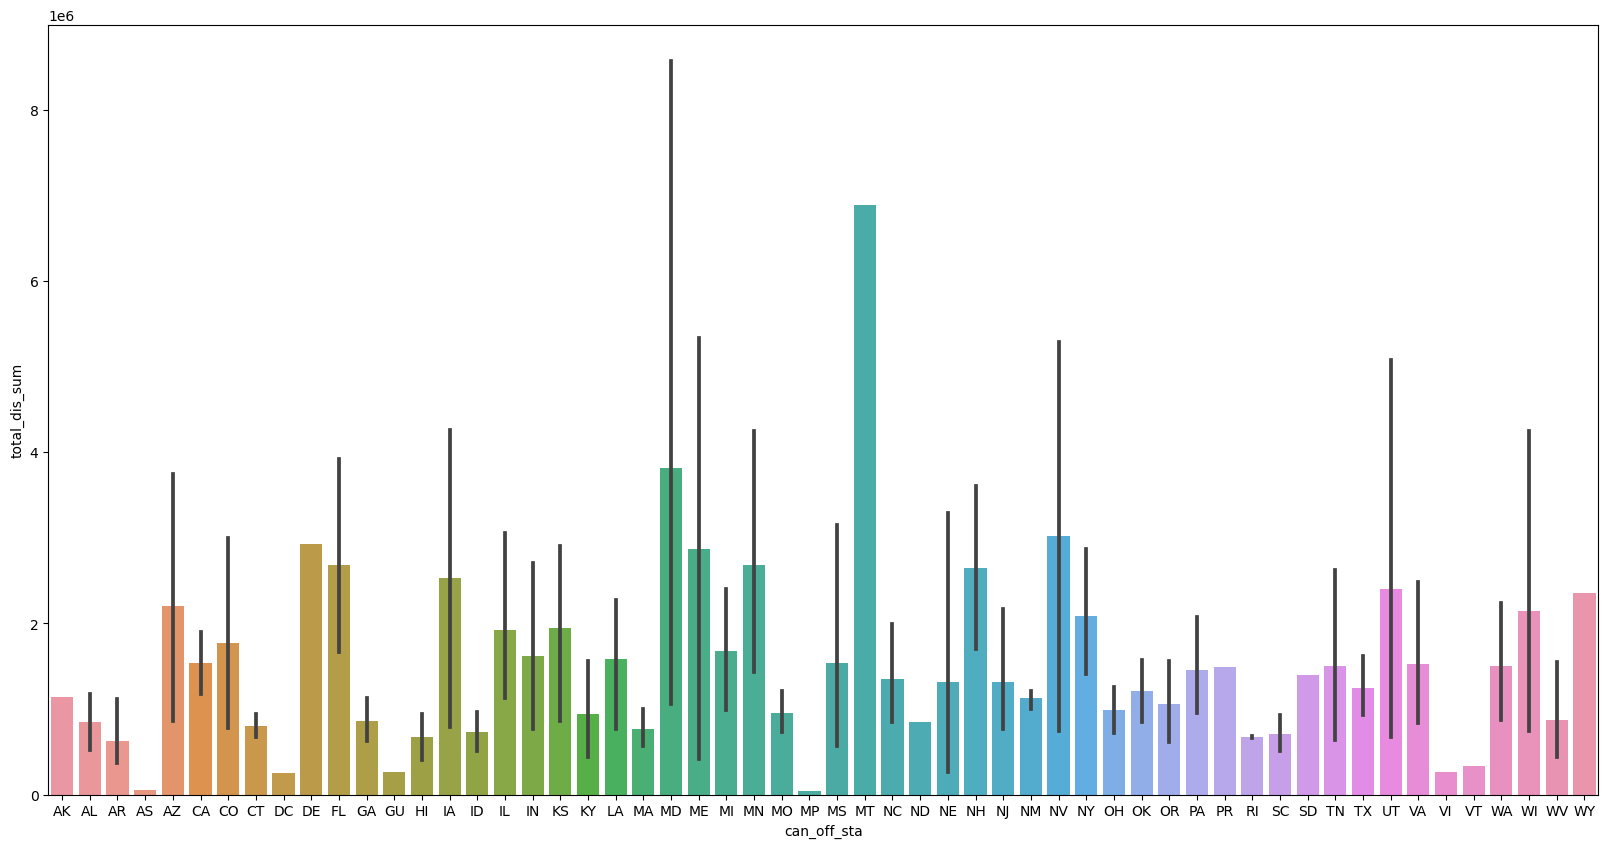

In [14]:
#visualize the state with high spending

plt.figure(figsize=(20,10))

ax = sns.barplot(x="can_off_sta", y="total_dis_sum", data=Amt_per_sta_ds)

In [15]:
mt_comp = H_df.loc[H_df['can_off_sta'] == 'MT']
mt_comp

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,WHITEFISH,MT,...,"$83,815.78","$399,122.61","$4,938,943.74",5055942.00,NaN,2015-01-01,2016-10-19,Y,280476.0,657
535,H6MT01095,"JUNEAU, DENISE",H,MT,0.0,DEM,CHALLENGER,PO BOX 563,HELENA,MT,...,NaN,"$491,337.79","$2,317,465.07",1831515.25,NaN,2015-11-04,2016-10-19,N,NaN,350


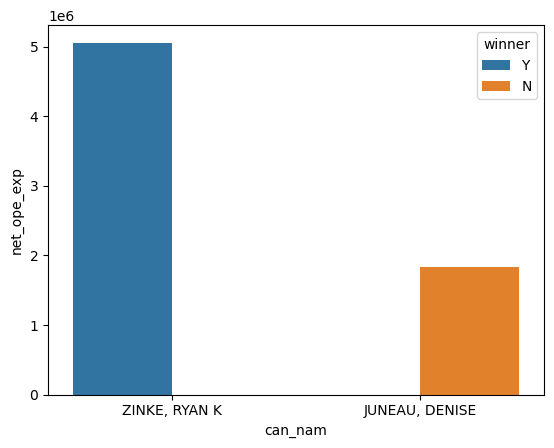

In [16]:
ax = sns.barplot(x='can_nam', y='net_ope_exp', hue = 'winner',data=mt_comp)

In [17]:
#Observation

#we can see the state has just one district with only two competitors, yet they have the higest rate of spending this can be due to a various reasons that are sadly not contained in the data. suggestions include:
#The cost of getting things done in that state is relatively high in comparison to other states
#Being in direct competition creates just one collision point for the candidates
#we can also see that the candidate with the highest spending won the election
#we can clearly see that for state MT with just one district, the higest spender won the vote, however, before we conclude, let's check how long each candidate campaigned for.

#reason behind this is the fact that time plays a role in the maturity of an investment. so assuming the campaign is the investemnt, net_con is the invested capital, how long will it take for the said investement to mature.
#naturally, the longer you keep your investment, the higher your profit gets, therefore, it should hold that the longer you campaign, the more likely it is for you to win, we check if this assumption holds

In [18]:
competitors = H_df.groupby(['can_off_sta', 'can_off_dis'])['can_id'].count().to_frame(name = "num_of_comp").reset_index()
#eliminate data points where num_of_comp <= 1
#this means that these positions are unopposed
competitors = competitors[competitors['num_of_comp'] > 1]

In [19]:
competitors.head()

,can_off_sta,can_off_dis,num_of_comp
1,AL,1.0,2
2,AL,2.0,3
3,AL,3.0,3
4,AL,4.0,2
5,AL,5.0,2


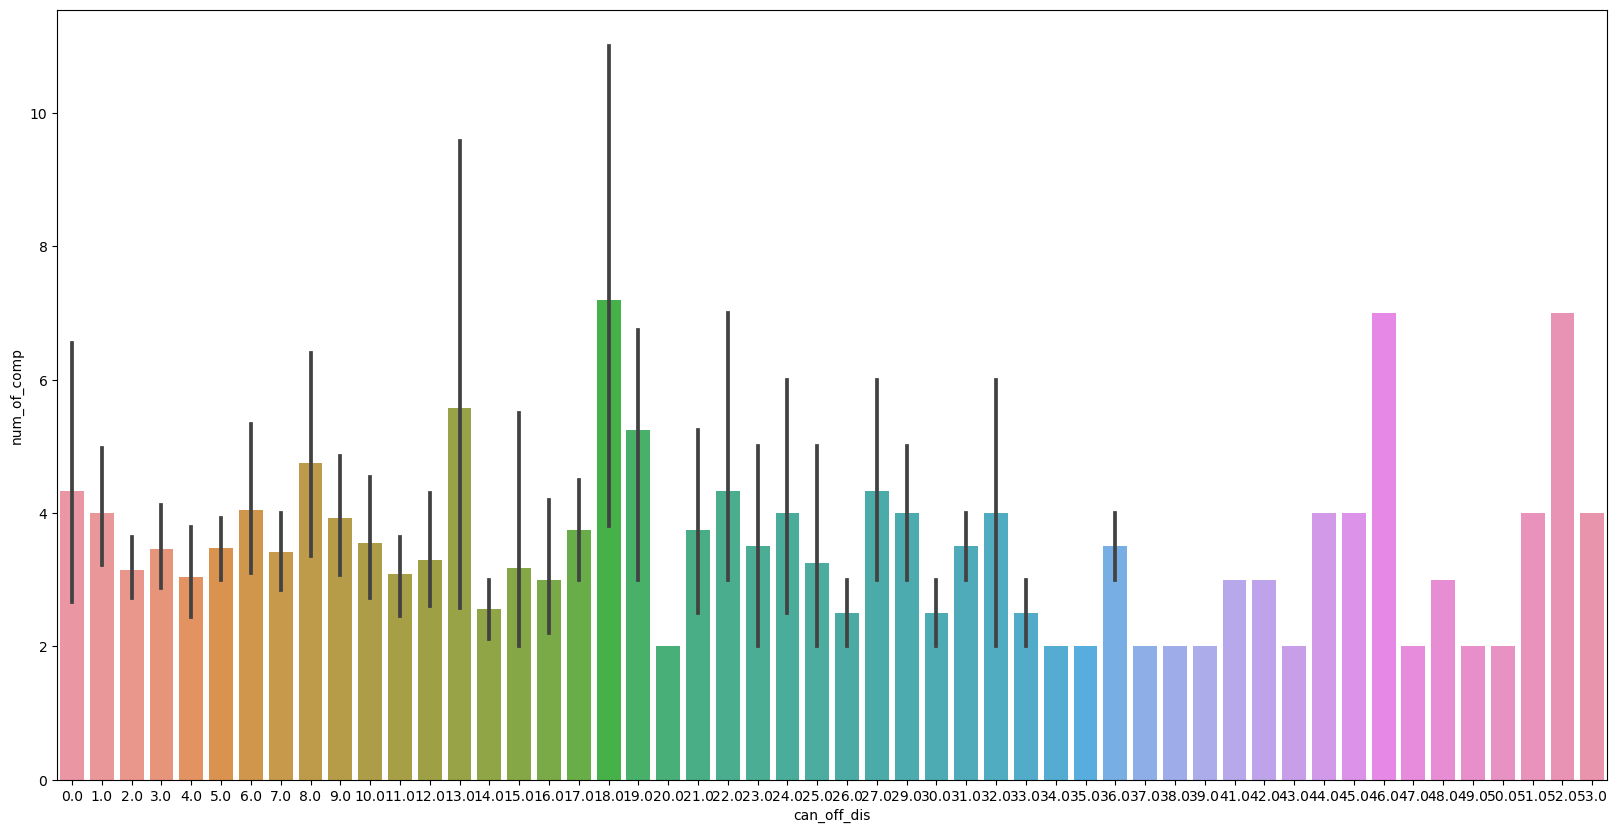

In [20]:
plt.figure(figsize=(20,10))

ax = sns.barplot(x="can_off_dis", y="num_of_comp", data=competitors)

In [21]:
al_comp = H_df.loc[H_df['can_off_sta'] == 'AL']
al_comp.shape

(15, 42)

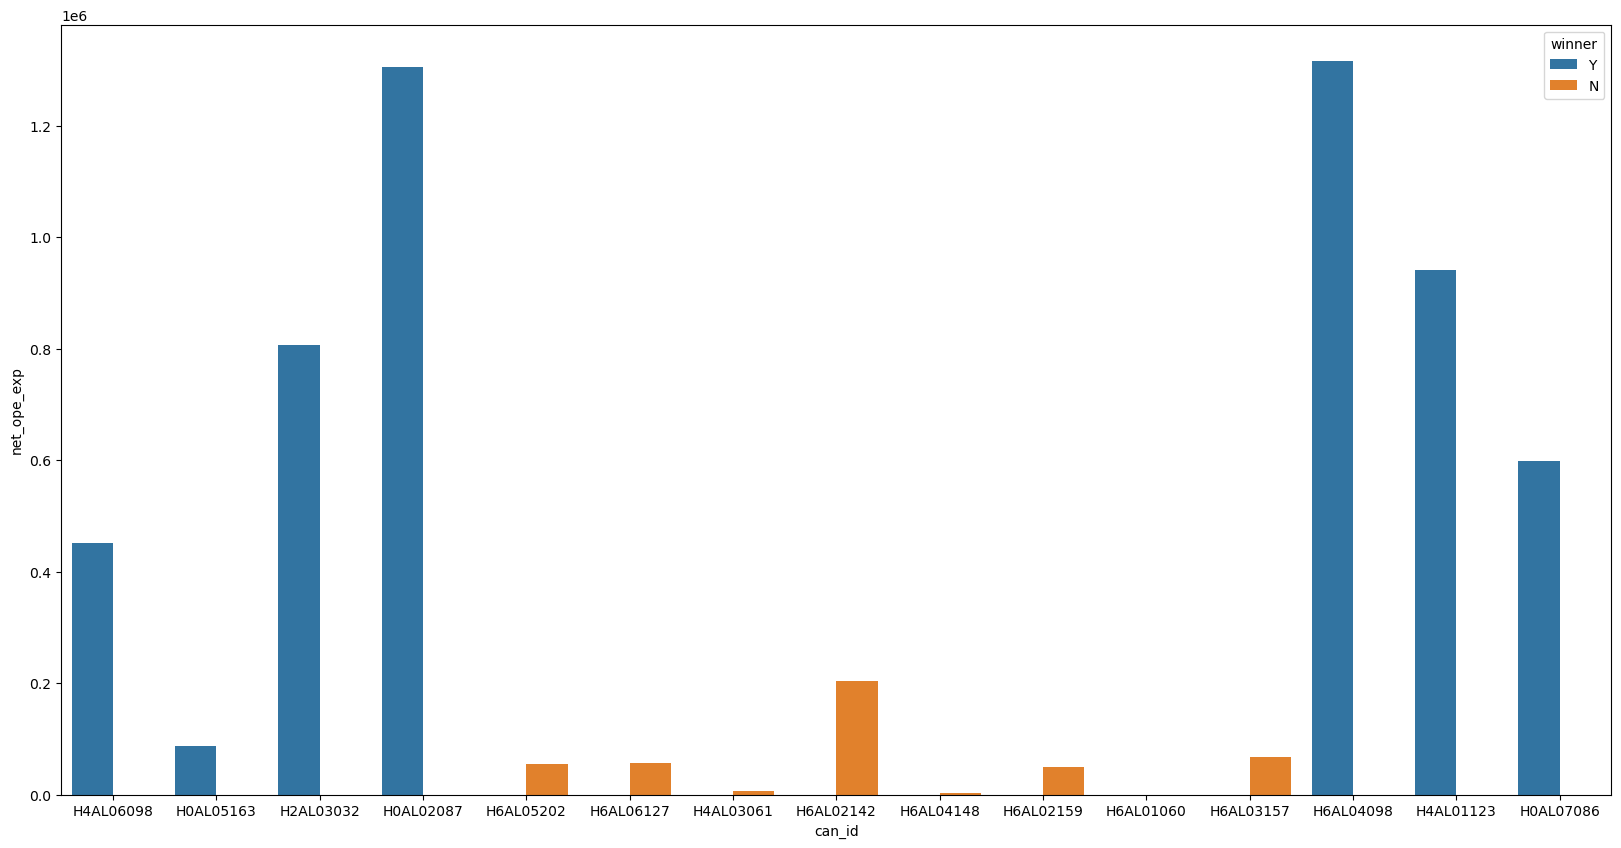

In [22]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x='can_id', y='net_ope_exp', hue = 'winner',data=al_comp)

C:\Users\Erdem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Erdem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Erdem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Erdem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

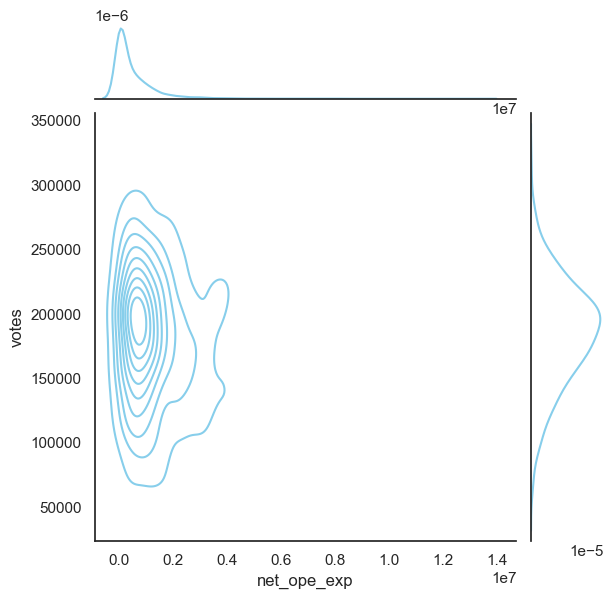

In [23]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style="white", color_codes=True)
sns.jointplot(x=H_df["net_ope_exp"], y=H_df["votes"], kind='kde', color="skyblue")

In [24]:
S_df.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
379,S6IL00292,"DUCKWORTH, L TAMMY",S,IL,0.0,DEM,CHALLENGER,PO BOX 10793,CHICAGO,IL,...,NaN,"$2,520,008.00","$13,059,804.00",12412571.0,NaN,2015-03-30,2016-10-19,Y,NaN,569
380,S6NH00091,"HASSAN, MARGARET WOOD",S,NH,0.0,DEM,CHALLENGER,PO BOX 298,CONCORD,NH,...,NaN,"$1,805,530.00","$14,006,424.00",13622825.0,NaN,2015-10-05,2016-10-19,Y,NaN,380
383,S6CO00309,"GRAHAM, JOHN COLLINS",S,CO,0.0,REP,CHALLENGER,PO BOX 101177,DENVER,CO,...,NaN,NaN,"$483,847.00",2358939.0,NaN,2016-01-01,2016-12-31,N,NaN,365
399,S0KS00166,"WIESNER, PATRICK",S,KS,0.0,DEM,CHALLENGER,2717 ANN COURT,LAWRENCE,KS,...,"$2,653.00","$8,070.00","$15,026.00",29603.0,"$20,000.00",2015-01-01,2016-10-28,N,NaN,666
402,S6OR05085,"STINE, KEVIN",S,OR,0.0,DEM,CHALLENGER,PO BOX 1209,MEDFORD,OR,...,NaN,NaN,"$5,735.00",6436.0,$702.00,2015-09-01,2016-10-25,N,NaN,420


In [25]:
prf1 = S_df['votes'].isna().count()
prf2 =  len(S_df['votes'])

print(prf1)
print(prf2)

227
227


In [26]:
S_df.drop(columns='votes', inplace=True)

C:\Users\Erdem\AppData\Local\Temp\ipykernel_18476\2679344681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S_df.drop(columns='votes', inplace=True)


In [27]:
S_df.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,campaign_duration
379,S6IL00292,"DUCKWORTH, L TAMMY",S,IL,0.0,DEM,CHALLENGER,PO BOX 10793,CHICAGO,IL,...,"$12,991,223.00",NaN,"$2,520,008.00","$13,059,804.00",12412571.0,NaN,2015-03-30,2016-10-19,Y,569
380,S6NH00091,"HASSAN, MARGARET WOOD",S,NH,0.0,DEM,CHALLENGER,PO BOX 298,CONCORD,NH,...,"$13,720,969.00",NaN,"$1,805,530.00","$14,006,424.00",13622825.0,NaN,2015-10-05,2016-10-19,Y,380
383,S6CO00309,"GRAHAM, JOHN COLLINS",S,CO,0.0,REP,CHALLENGER,PO BOX 101177,DENVER,CO,...,"$2,365,130.00",NaN,NaN,"$483,847.00",2358939.0,NaN,2016-01-01,2016-12-31,N,365
399,S0KS00166,"WIESNER, PATRICK",S,KS,0.0,DEM,CHALLENGER,2717 ANN COURT,LAWRENCE,KS,...,"$29,603.00","$2,653.00","$8,070.00","$15,026.00",29603.0,"$20,000.00",2015-01-01,2016-10-28,N,666
402,S6OR05085,"STINE, KEVIN",S,OR,0.0,DEM,CHALLENGER,PO BOX 1209,MEDFORD,OR,...,"$8,733.00",NaN,NaN,"$5,735.00",6436.0,$702.00,2015-09-01,2016-10-25,N,420


In [28]:
#first, we check amount spent per state 
Amt_per_sta_ds = S_df.groupby(['can_off_sta', 'can_off_dis'])['net_ope_exp'].sum().to_frame(name = "total_dis_sum").reset_index()
Amt_per_sta_ds.head()

,can_off_sta,can_off_dis,total_dis_sum
0,AK,0.0,5250057.0
1,AL,0.0,12234151.0
2,AR,0.0,4802073.0
3,AZ,0.0,20388834.0
4,CA,0.0,16926962.0


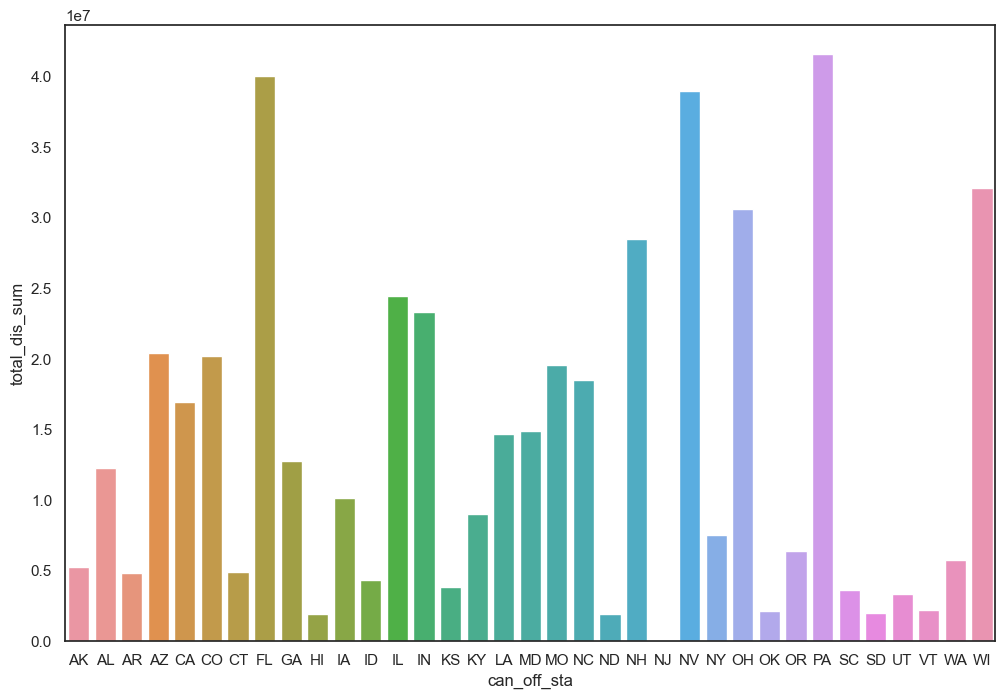

In [29]:
#visualize to see the highest spending state

plt.Figure(figsize=(20,10))
ax = sns.barplot(x='can_off_sta', y='total_dis_sum', data=Amt_per_sta_ds)

In [30]:
#create the three dataframes
fl_comp = S_df.loc[S_df['can_off_sta'] == 'FL']
pa_comp = S_df.loc[S_df['can_off_sta'] == 'PA']
nv_comp = S_df.loc[S_df['can_off_sta'] == 'NV']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'DALACK, BASIL EDWARD'),
  Text(1, 0, 'JOLLY, DAVID W'),
  Text(2, 0, 'KHOURY, ANTON'),
  Text(3, 0, 'MURPHY, PATRICK E'),
  Text(4, 0, 'NATHAN, BRUCE'),
  Text(5, 0, 'STANTON, PAUL ANTHONY'),
  Text(6, 0, 'DE LA FUENTA, ROQUE ROCKY'),
  Text(7, 0, 'GRAYSON, ALAN MARK'),
  Text(8, 0, 'GUTHRIE, SEAN PATRICK'),
  Text(9, 0, 'HARIDOPOLOS, MIKE'),
  Text(10, 0, 'KEITH, PAMELA MICHELE'),
  Text(11, 0, 'LOPEZ-CANTERA, CARLOS'),
  Text(12, 0, 'LUSTER, REGINALD'),
  Text(13, 0, 'RIVERA, ERNESTO J'),
  Text(14, 0, 'YOUNG, DWIGHT MARK ANTHONY'),
  Text(15, 0, 'BERUFF, CARLOS'),
  Text(16, 0, 'INVICTUS, AUGUSTUS SOL'),
  Text(17, 0, 'MACHAT, STEVEN'),
  Text(18, 0, 'LAROSE, JOSH'),
  Text(19, 0, 'RUBIO, MARCO')])

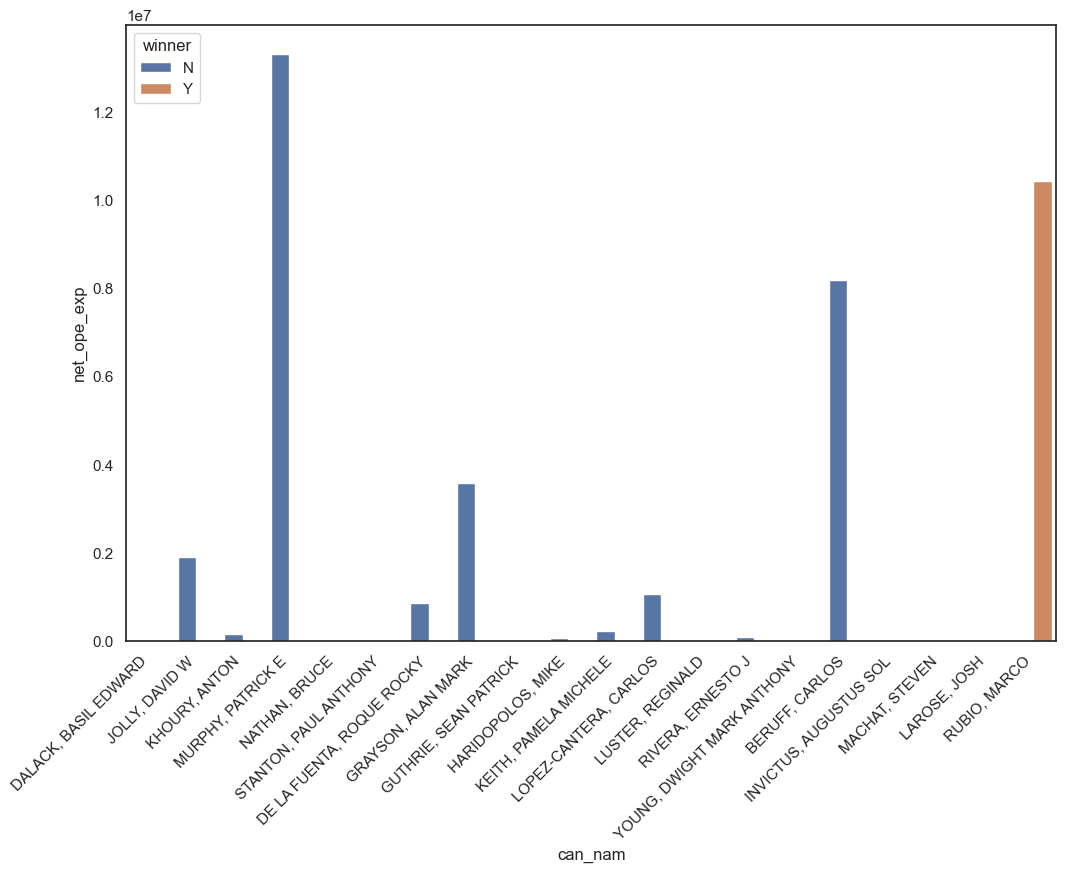

In [31]:
#check winners in FL

ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='winner', data=fl_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

In [32]:
fl_comp.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,campaign_duration
470,S6FL00459,"DALACK, BASIL EDWARD",S,FL,0.0,REP,CHALLENGER,225 GOLFVIEW DRIVE,TEQUESTA,FL,...,"$7,318.00",NaN,$0.92,"$5,220.00",10.0,NaN,2016-04-13,2016-10-19,N,189
532,S6FL00350,"JOLLY, DAVID W",S,FL,0.0,REP,CHALLENGER,PO BOX 1158,INDIAN ROCKS BEACH,FL,...,"$1,970,657.96","$246,339.09","$158,630.58","$1,826,909.95",1915656.0,NaN,2015-01-01,2016-10-19,N,657
542,S6FL00434,"KHOURY, ANTON",S,FL,0.0,OTH,CHALLENGER,PO BOX 565087,MIAMI,FL,...,"$171,969.00",NaN,"$42,098.00","$73,821.00",171719.0,"$140,000.00",2016-01-01,2016-10-19,N,292
597,S6FL00319,"MURPHY, PATRICK E",S,FL,0.0,DEM,CHALLENGER,4521 PGA BLVD #412,PALM BEACH GARDENS,FL,...,"$13,438,036.00","$536,659.00","$1,642,826.00","$13,682,705.00",13324181.0,NaN,2015-01-01,2016-10-19,N,657
599,S6FL00327,"NATHAN, BRUCE",S,FL,0.0,IND,CHALLENGER,3230 SW ISLAND WAY,PALM CITY,FL,...,"$17,710.00",NaN,$4.00,"$3,116.00",17150.0,"$14,041.00",2015-06-20,2016-10-19,N,487


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'DALACK, BASIL EDWARD'),
  Text(1, 0, 'JOLLY, DAVID W'),
  Text(2, 0, 'KHOURY, ANTON'),
  Text(3, 0, 'MURPHY, PATRICK E'),
  Text(4, 0, 'NATHAN, BRUCE'),
  Text(5, 0, 'STANTON, PAUL ANTHONY'),
  Text(6, 0, 'DE LA FUENTA, ROQUE ROCKY'),
  Text(7, 0, 'GRAYSON, ALAN MARK'),
  Text(8, 0, 'GUTHRIE, SEAN PATRICK'),
  Text(9, 0, 'HARIDOPOLOS, MIKE'),
  Text(10, 0, 'KEITH, PAMELA MICHELE'),
  Text(11, 0, 'LOPEZ-CANTERA, CARLOS'),
  Text(12, 0, 'LUSTER, REGINALD'),
  Text(13, 0, 'RIVERA, ERNESTO J'),
  Text(14, 0, 'YOUNG, DWIGHT MARK ANTHONY'),
  Text(15, 0, 'BERUFF, CARLOS'),
  Text(16, 0, 'INVICTUS, AUGUSTUS SOL'),
  Text(17, 0, 'MACHAT, STEVEN'),
  Text(18, 0, 'LAROSE, JOSH'),
  Text(19, 0, 'RUBIO, MARCO')])

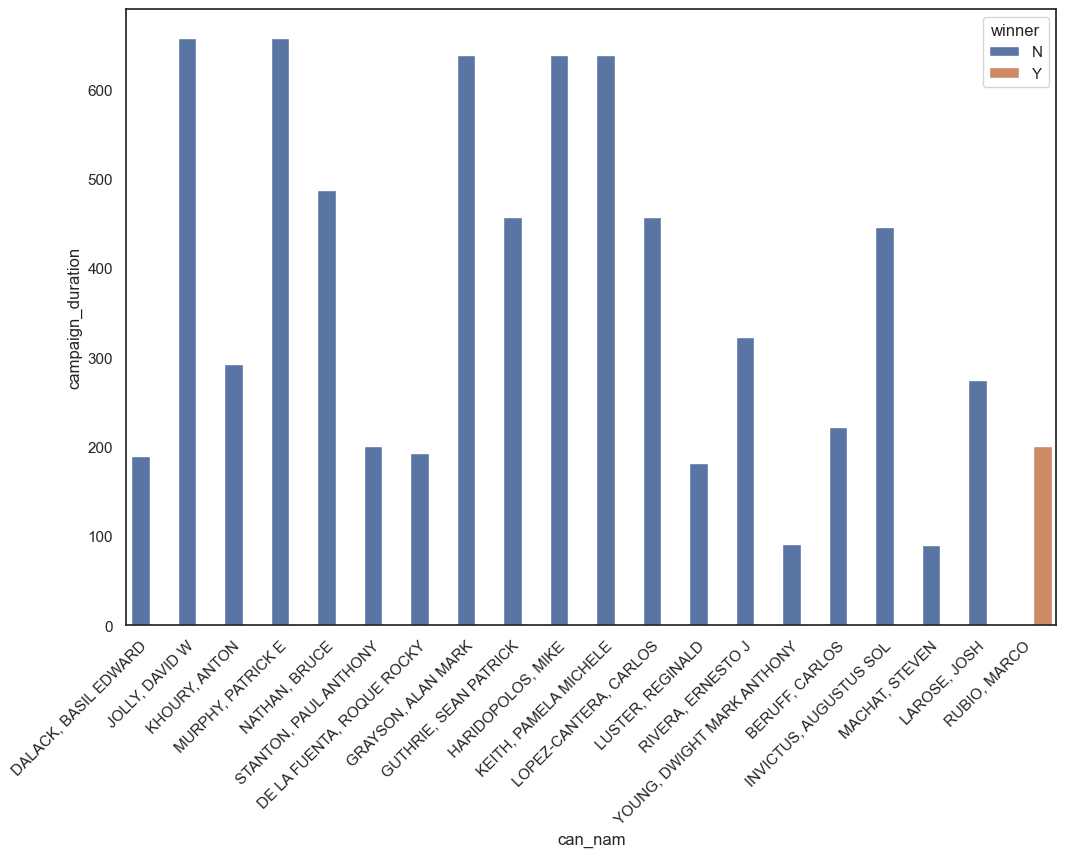

In [33]:
ax = sns.barplot(x='can_nam', y='campaign_duration', hue='winner', data=fl_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'DALACK, BASIL EDWARD'),
  Text(1, 0, 'JOLLY, DAVID W'),
  Text(2, 0, 'KHOURY, ANTON'),
  Text(3, 0, 'MURPHY, PATRICK E'),
  Text(4, 0, 'NATHAN, BRUCE'),
  Text(5, 0, 'STANTON, PAUL ANTHONY'),
  Text(6, 0, 'DE LA FUENTA, ROQUE ROCKY'),
  Text(7, 0, 'GRAYSON, ALAN MARK'),
  Text(8, 0, 'GUTHRIE, SEAN PATRICK'),
  Text(9, 0, 'HARIDOPOLOS, MIKE'),
  Text(10, 0, 'KEITH, PAMELA MICHELE'),
  Text(11, 0, 'LOPEZ-CANTERA, CARLOS'),
  Text(12, 0, 'LUSTER, REGINALD'),
  Text(13, 0, 'RIVERA, ERNESTO J'),
  Text(14, 0, 'YOUNG, DWIGHT MARK ANTHONY'),
  Text(15, 0, 'BERUFF, CARLOS'),
  Text(16, 0, 'INVICTUS, AUGUSTUS SOL'),
  Text(17, 0, 'MACHAT, STEVEN'),
  Text(18, 0, 'LAROSE, JOSH'),
  Text(19, 0, 'RUBIO, MARCO')])

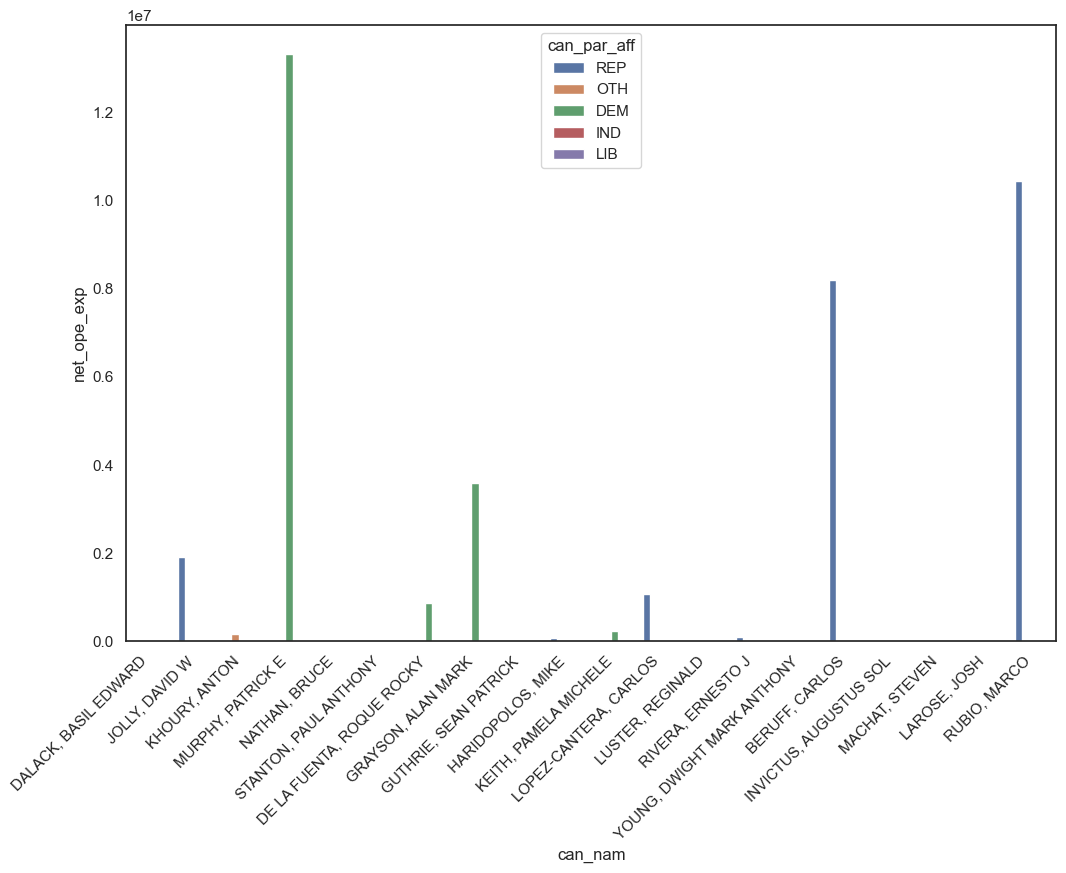

In [34]:
ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='can_par_aff', data=fl_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

<Axes: xlabel='can_par_aff'>

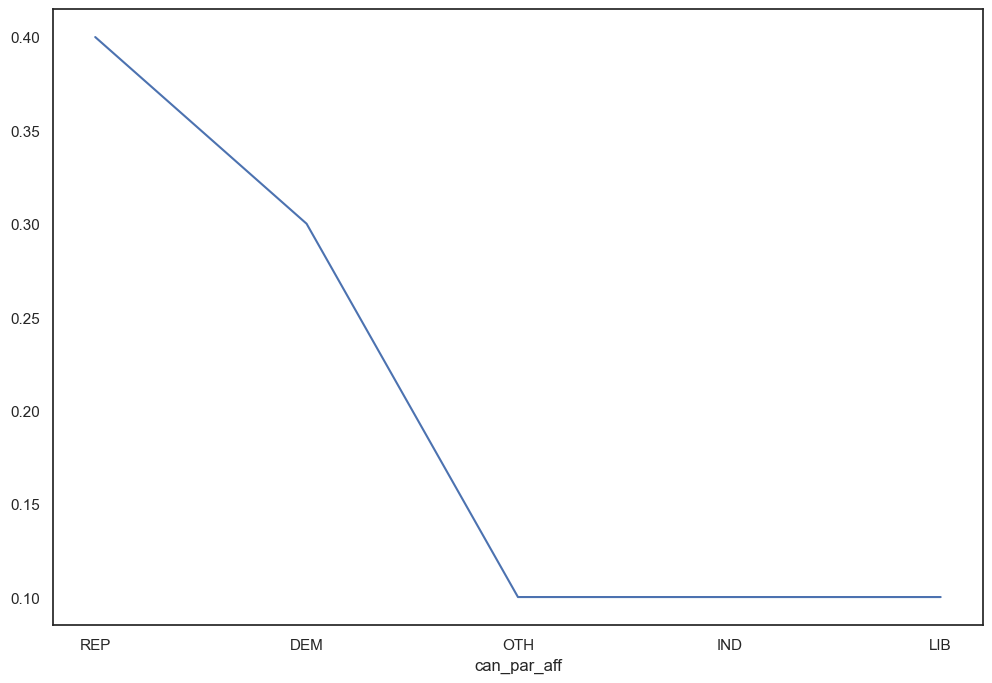

In [35]:
fl_comp['can_par_aff'].value_counts(normalize=True, sort=True).plot()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'MCGINTY, KATHLEEN ALANA'),
  Text(1, 0, 'FETTERMAN, JOHN KART'),
  Text(2, 0, 'PAWLOWSKI, ED'),
  Text(3, 0, 'SESTAK, JOSEPH A JR'),
  Text(4, 0, 'STERN, EVERETT ALEXANDER'),
  Text(5, 0, 'VODVARKA, JOSEPH JOHN'),
  Text(6, 0, 'HUDOCK, BRANDON GENE'),
  Text(7, 0, 'TOOMEY, PATRICK JOSEPH')])

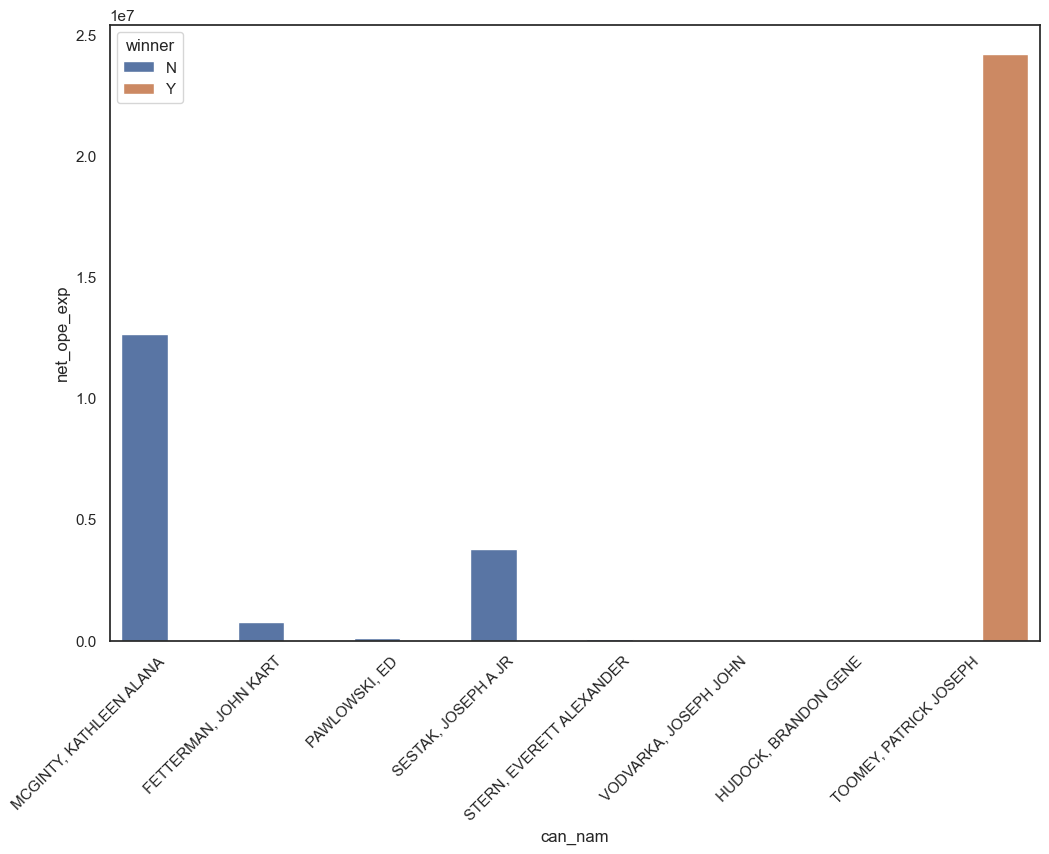

In [36]:
#check winners in PA

ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='winner', data=pa_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

Text(0.5, 1.0, 'campaign duration')

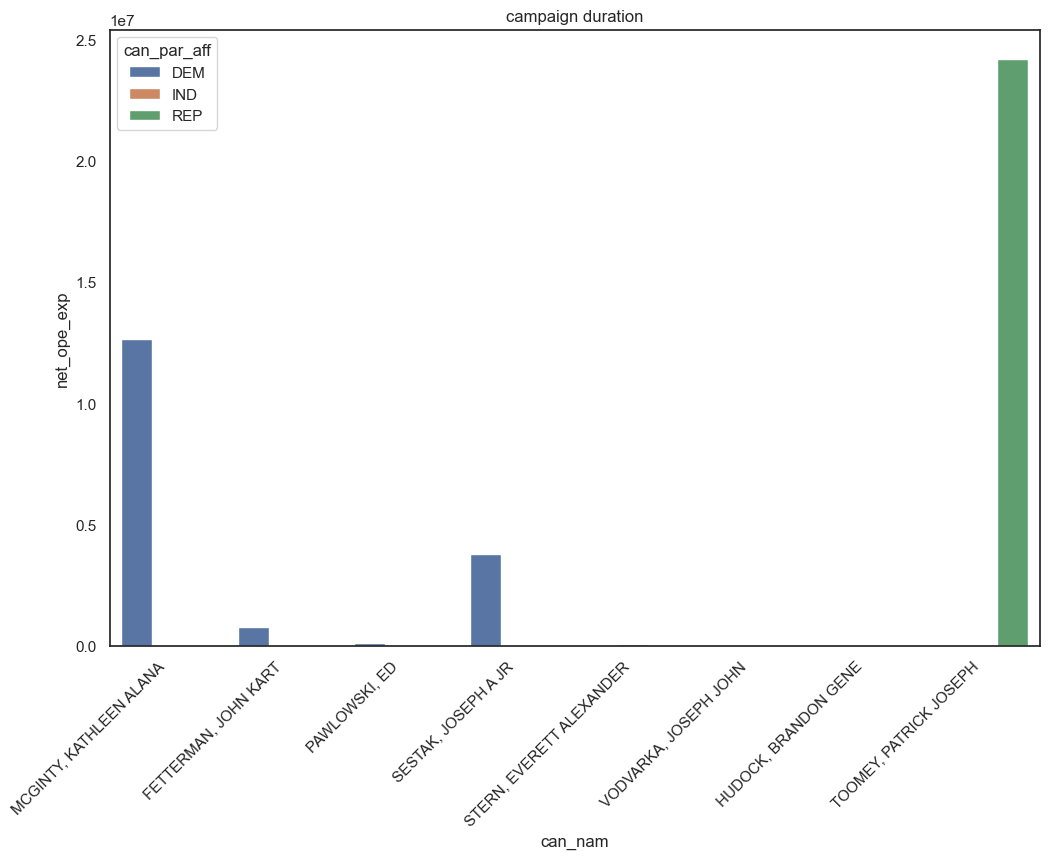

In [37]:
ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='can_par_aff', data=pa_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MASTO, CATHERINE CORTEZ'),
  Text(1, 0, 'GUMINA, TONY DR'),
  Text(2, 0, 'HECK, JOE'),
  Text(3, 0, 'WILLIAMS, JARROD M.'),
  Text(4, 0, 'ANGLE, SHARRON E'),
  Text(5, 0, 'MAHENDRA, SUJEET BOBBY NARENDRA'),
  Text(6, 0, 'TARBELL, BILL'),
  Text(7, 0, 'HECK, THOMAS'),
  Text(8, 0, 'BEERS, ROBERT T'),
  Text(9, 0, 'JONES, THOMAS FRANKLIN')])

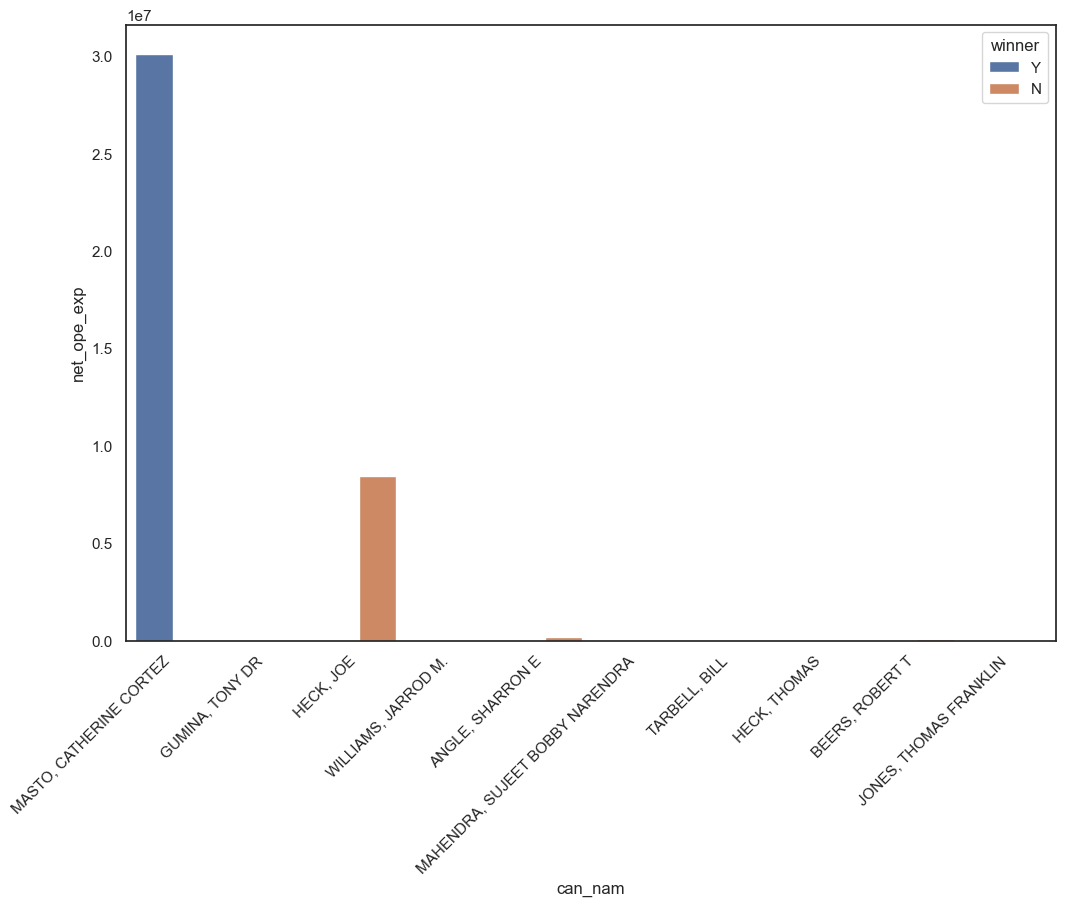

In [38]:
#check winners in PA

ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='winner', data=nv_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

Text(0.5, 1.0, 'campaign duration')

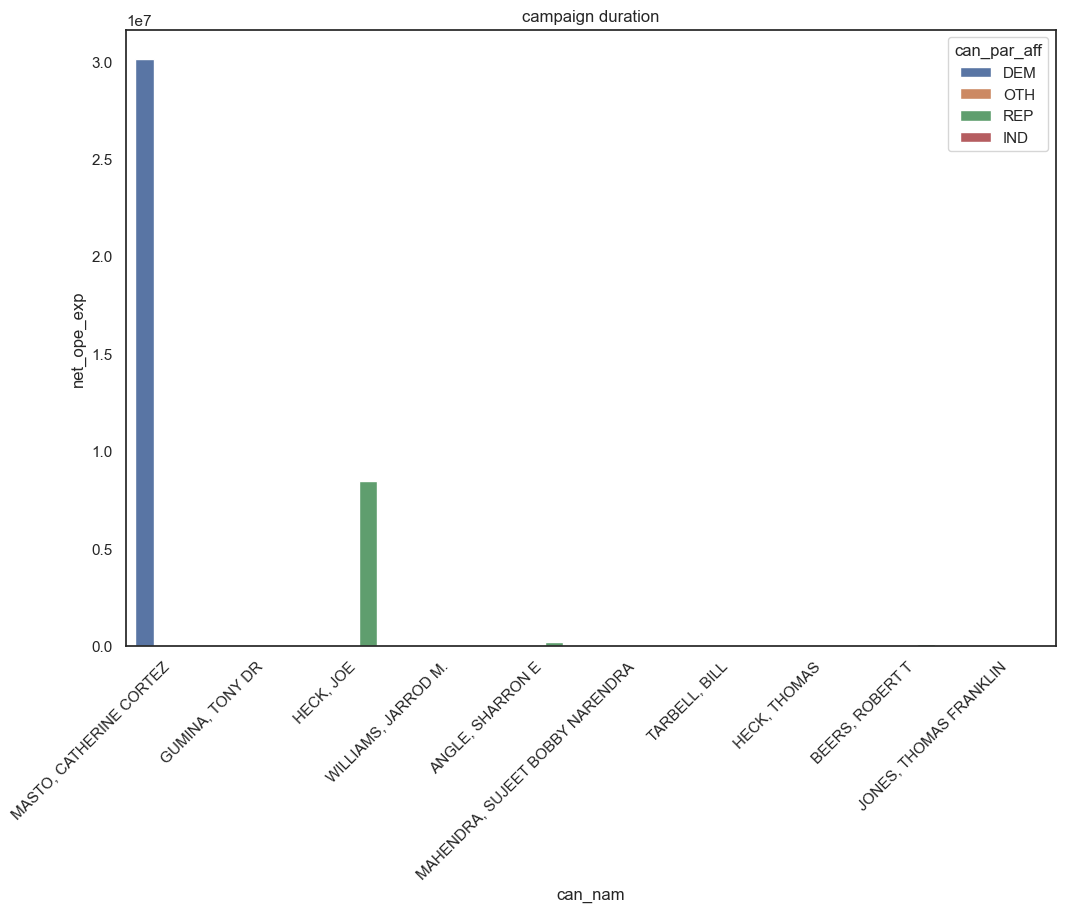

In [40]:
ax = sns.barplot(x='can_nam', y='net_ope_exp', hue='can_par_aff', data=nv_comp)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")

In [41]:
P_df.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,cov_sta_dat,cov_end_dat,winner,votes,campaign_duration
1199,P20000089,"FELLURE, LOWELL JACKSON",P,US,0.0,REP,CHALLENGER,682 ORCHARD PARK ROAD,HURRICANE,WV,...,$590.00,$590.00,NaN,NaN,"$3,762.00",2015-01-01,2015-09-30,N,NaN,272
1208,P60006202,"JONES, DANNY ROYCE MR. SR.",P,US,0.0,REP,CHALLENGER,609 SW 1ST STREET,KERENS,TX,...,NaN,NaN,NaN,NaN,NaN,2015-01-01,2015-06-30,N,NaN,180
1319,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",P,US,0.0,REP,OPEN,725 FIFTH AVENUE,NEW YORK,NY,...,NaN,"$15,994,453.57","$468,441,873.44",923651008.0,"$2,086,572.41",2015-04-02,2016-10-19,Y,NaN,566
1322,P60005154,"CLARK, BRITTANY",P,US,0.0,PPY,OPEN,"28200 HIGHWAY 189, SUITE F-240-20",LAKE ARROWHEAD,CA,...,NaN,"$6,453.00",NaN,NaN,"$19,586.00",2016-01-31,2017-01-31,N,NaN,366
1323,P60016383,"KITTINGTON, VALMA",P,US,0.0,REP,OPEN,79 RANDOLPH STREET,MIDLAND CITY,AL,...,NaN,NaN,NaN,NaN,NaN,2015-07-15,2016-12-31,N,NaN,535


In [42]:
P_df.shape

(158, 42)

In [43]:
#create dataframe grouped by total amount spent
Amt_per_sta_ds = P_df.groupby(['can_nam', 'winner', 'can_par_aff', 'campaign_duration'])['net_ope_exp'].sum().to_frame(name = "total_dis_sum")

In [44]:
#sort result
Amt_per_sta_ds = Amt_per_sta_ds.sort_values(by = ['total_dis_sum'], ascending=False).reset_index()

<Axes: >

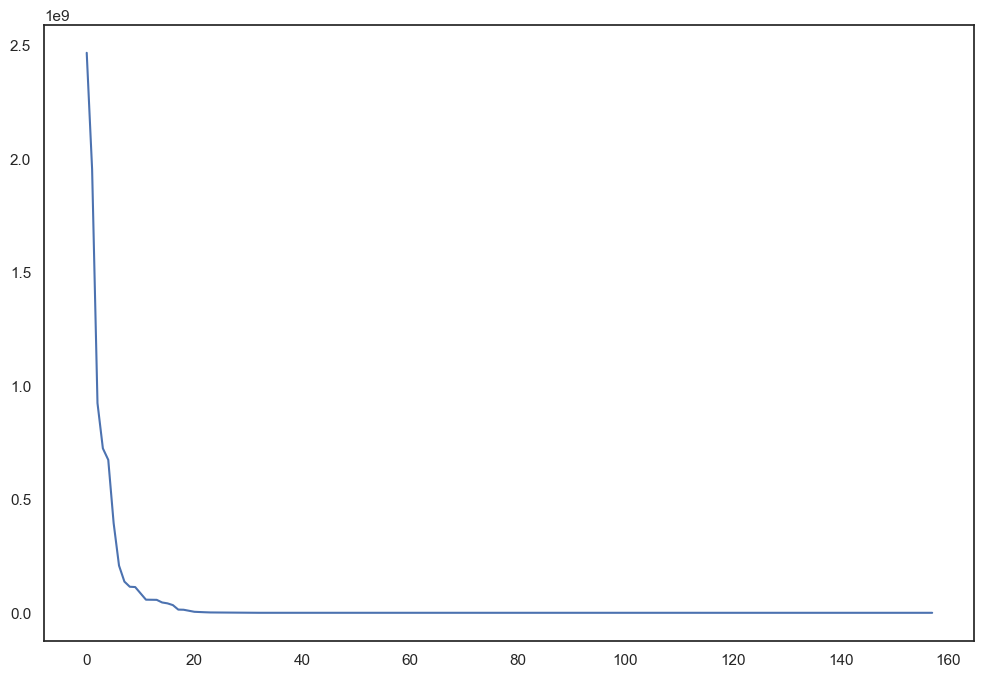

In [45]:
#create visualization to reach an assumption on which section of the data points could be candidates to win the election
Amt_per_sta_ds['total_dis_sum'].plot()

In [46]:
# select first 20 data points as candidates
Amt_per_sta_ds = Amt_per_sta_ds.iloc[:20, :]
Amt_per_sta_ds

,can_nam,winner,can_par_aff,campaign_duration,total_dis_sum
0,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",N,DEM,567,2.466802e+09
1,"SANDERS, BERNARD",N,DEM,567,1.954397e+09
2,"TRUMP, DONALD J. / MICHAEL R. PENCE",Y,REP,566,9.236510e+08
3,"CRUZ, RAFAEL EDWARD TED""""",N,REP,638,7.243084e+08
4,"CARSON, BENJAMIN S SR MD",N,REP,669,6.736959e+08
5,"RUBIO, MARCO",N,REP,638,3.948998e+08
6,"BUSH, JEB",N,REP,548,2.078283e+08
7,"PAUL, RAND",N,REP,579,1.374392e+08
8,"FIORINA, CARLY",N,REP,579,1.147676e+08
9,"KASICH, JOHN R",N,REP,457,1.134625e+08


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE'),
  Text(1, 0, 'SANDERS, BERNARD'),
  Text(2, 0, 'TRUMP, DONALD J. / MICHAEL R. PENCE '),
  Text(3, 0, 'CRUZ, RAFAEL EDWARD TED""'),
  Text(4, 0, 'CARSON, BENJAMIN S SR MD'),
  Text(5, 0, 'RUBIO, MARCO'),
  Text(6, 0, 'BUSH, JEB'),
  Text(7, 0, 'PAUL, RAND'),
  Text(8, 0, 'FIORINA, CARLY'),
  Text(9, 0, 'KASICH, JOHN R'),
  Text(10, 0, 'WALKER, SCOTT'),
  Text(11, 0, 'GRAHAM, LINDSEY O'),
  Text(12, 0, "O'MALLEY, MARTIN JOSEPH"),
  Text(13, 0, 'CHRISTIE, CHRISTOPHER J'),
  Text(14, 0, 'HUCKABEE, MIKE'),
  Text(15, 0, 'JOHNSON, GARY / WILLIAM BILL" WELD"'),
  Text(16, 0, 'DE  LA  FUENTE, ROQUE ROCKY'),
  Text(17, 0, 'SANTORUM, RICHARD J.'),
  Text(18, 0, 'STEIN, JILL'),
  Text(19, 0, 'PERRY, JAMES R (RICK)')])

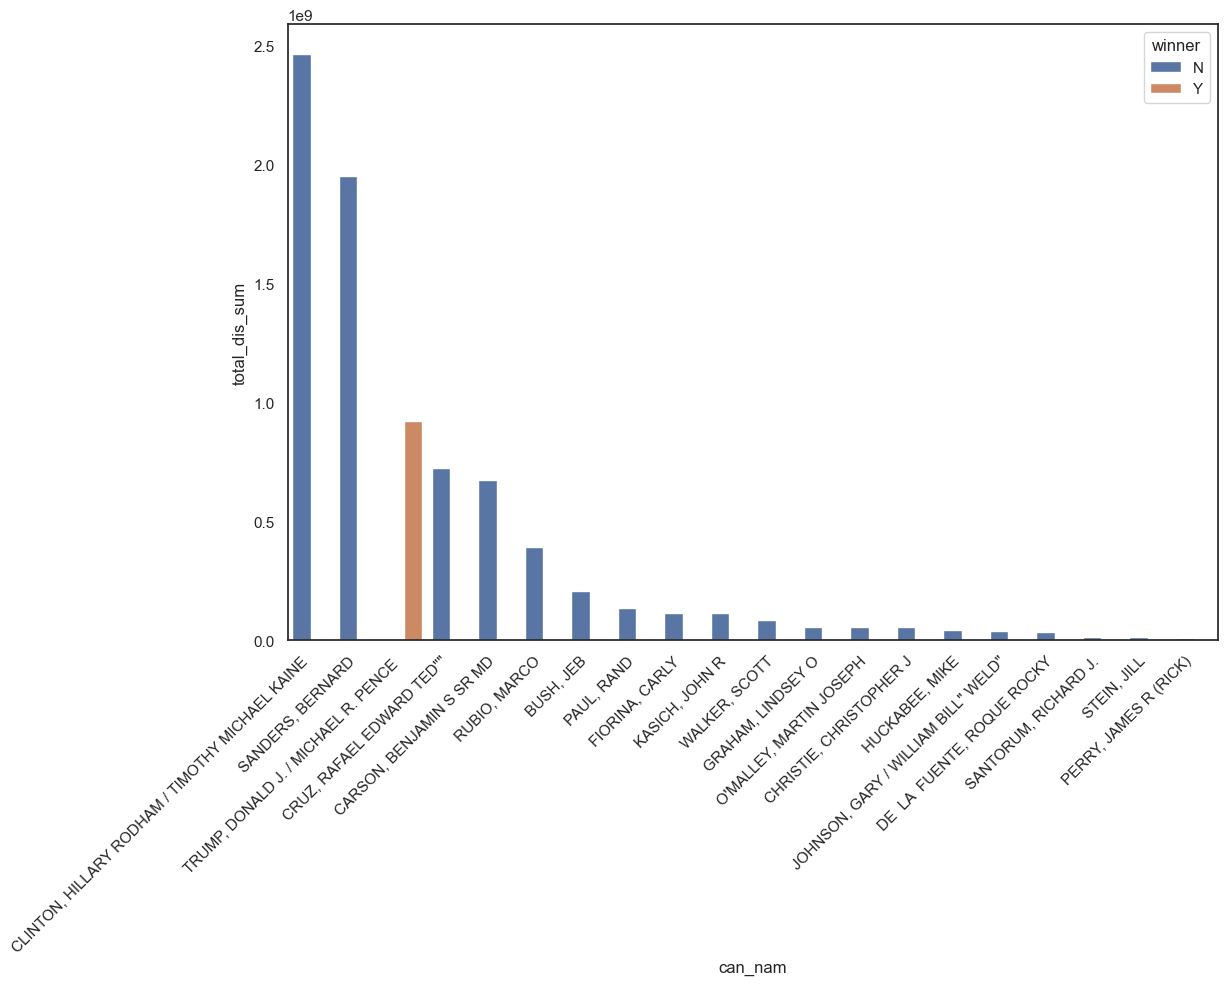

In [47]:
#check winner
ax = sns.barplot(x='can_nam', y = 'total_dis_sum', hue='winner', data=Amt_per_sta_ds)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

In [50]:
plt.style.use('seaborn-white')
plt.subplot(121)
ax = sns.barplot(x='can_nam', y='campaign_duration', hue='winner', data=Amt_per_sta_ds)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")


plt.subplot(122)
Amt_per_sta_ds['can_par_aff'].value_counts(normalize=True, sort=True).plot()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("dominant party")
ax = sns.barplot(x='can_nam', y='total_dis_sum', hue='can_par_aff', data=Amt_per_sta_ds)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)
plt.title("campaign duration")

OSError: 'seaborn-white' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [51]:
#create regression data
Regression_data = data[['can_off', 'can_off_sta', 'can_off_dis', 'can_inc_cha_ope_sea', 'net_ope_exp', 'can_par_aff','campaign_duration','votes']]


#create classification data
Classification_data = data[['can_off', 'can_off_sta', 'can_off_dis', 'can_inc_cha_ope_sea', 'net_ope_exp', 'can_par_aff','campaign_duration','winner']]

In [52]:
Regression_data.isna().sum()/len(Regression_data)

can_off                0.000000
can_off_sta            0.000000
can_off_dis            0.001103
can_inc_cha_ope_sea    0.001103
net_ope_exp            0.082139
can_par_aff            0.000551
campaign_duration      0.000000
votes                  0.791069
dtype: float64

In [53]:
Classification_data.isna().sum()

can_off                  0
can_off_sta              0
can_off_dis              2
can_inc_cha_ope_sea      2
net_ope_exp            149
can_par_aff              1
campaign_duration        0
winner                   0
dtype: int64

In [54]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

Classification_data['can_off_dis'] = imp_mode.fit_transform(Classification_data[['can_off_dis']]).copy()
Classification_data['can_inc_cha_ope_sea'] = imp_mode.fit_transform(Classification_data[['can_inc_cha_ope_sea']]).copy()
Classification_data['net_ope_exp'] = Classification_data['net_ope_exp'].fillna(-99999999999999999999999).copy()
Classification_data['can_par_aff'] = imp_mode.fit_transform(Classification_data[['can_par_aff']]).copy()

C:\Users\Erdem\AppData\Local\Temp\ipykernel_18476\3304821253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Classification_data['can_off_dis'] = imp_mode.fit_transform(Classification_data[['can_off_dis']]).copy()


ValueError: 2

In [55]:
Classification_data.isna().sum()

can_off                  0
can_off_sta              0
can_off_dis              0
can_inc_cha_ope_sea      2
net_ope_exp            149
can_par_aff              1
campaign_duration        0
winner                   0
dtype: int64

In [56]:
Classification_data = Classification_data[Classification_data.can_par_aff != 'PPT']

In [57]:
#make respective dataframes
H_model_data_cla = Classification_data.loc[Classification_data['can_off'] == 'H']
P_model_data_cla = Classification_data.loc[Classification_data['can_off'] == 'P']
S_model_data_cla = Classification_data.loc[Classification_data['can_off'] == 'S']

In [58]:
from sklearn.model_selection import train_test_split

X = H_model_data_cla.iloc[:,:-1]
y = H_model_data_cla.iloc[:,-1]

In [59]:
# determine categorical and numerical features



numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns


# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

In [60]:
# define base the model

model = XGBClassifier(learning_rate=0.1,min_child_weight=100)
# define the data preparation and modeling pipeline
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model) ])

In [61]:
X.isna().sum()

can_off                 0
can_off_sta             0
can_off_dis             0
can_inc_cha_ope_sea     2
net_ope_exp            43
can_par_aff             1
campaign_duration       0
dtype: int64

In [62]:
#divide data into train and test split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=0)

In [65]:
pipeline.fit(X_train, y_train)
print(confusion_matrix(y_true=y_val, y_pred=y_pred))
print(f'accuracy of the base model on house of rep election is {accuracy_score(y_val, y_pred) * 100}%')

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['N' 'Y']

In [64]:
y_pred = pipeline.predict(X_val)

NotFittedError: need to call fit or load_model beforehand

In [66]:
def test_model_(models_dict, X_train, y_train, X_val, y_val):
    """
    a function that takes in a dictionary of models along with train and test data
    to calculate the f1_score and accuracy score of the built pipeline then return a dataframe as the output
    
    """
    metrics = {}
    for i in models_dict:
        model_name = str(i)
        model = models_dict[i]
        
        pipeline = Pipeline(steps=[('prep',col_transform), ('m', model) ])
        pipeline.fit(X_train, y_train)
        test_pred = pipeline.predict(X_val)
        metric_1 = accuracy_score(y_val, test_pred) * 100
        metric_2 = f1_score(y_val, test_pred, average='weighted')
        metrics[i] = metric_1, metric_2
        
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Accuracy score', 'f1_score'])
    return metrics_df
        

In [67]:
#create a dictionary of classification models
candidate_models = {'xgboost':XGBClassifier(), 'log_reg': LogisticRegression(), 'svm':SVC(), 'random forest': RandomForestClassifier() }

#cal test_model_function
test_model_(candidate_models, X_train, y_train, X_val, y_val)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['N' 'Y']